In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, f1_score, auc, RocCurveDisplay, recall_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer


<h2>Reading and displaying dataset</h2>

In [2]:
#reading and displaying the dataset

dataset = pd.read_csv("BankNote_Authentication.csv")
dataset.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


<h2>Plot matrix and Boxplot</h2>
<p>We use the plot matrix to see the relation between each features and detect patterns. With boxplot we can detect outliers in each features.</p>

<Figure size 432x288 with 0 Axes>

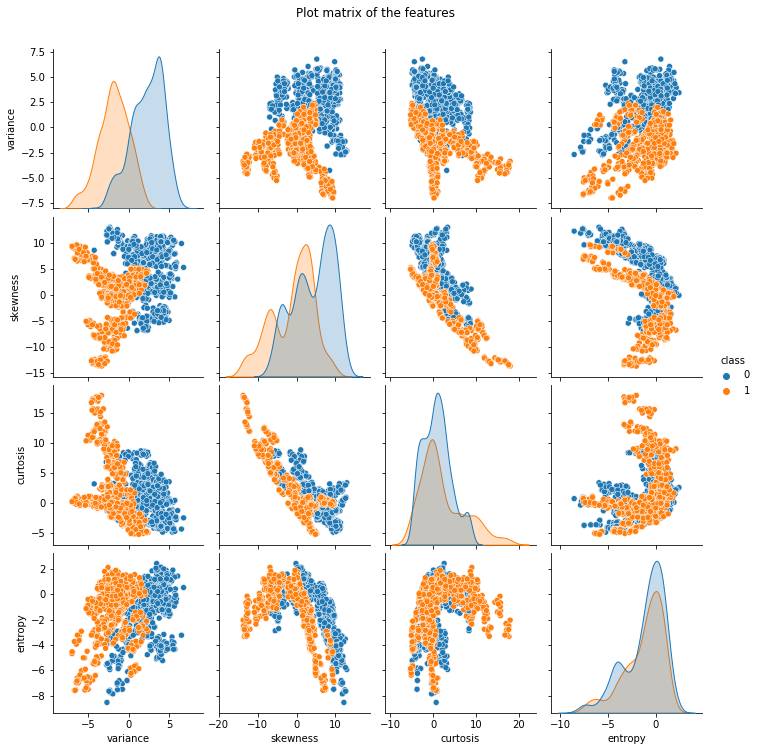

Text(0.5, 0.98, 'Boxplot of the features')

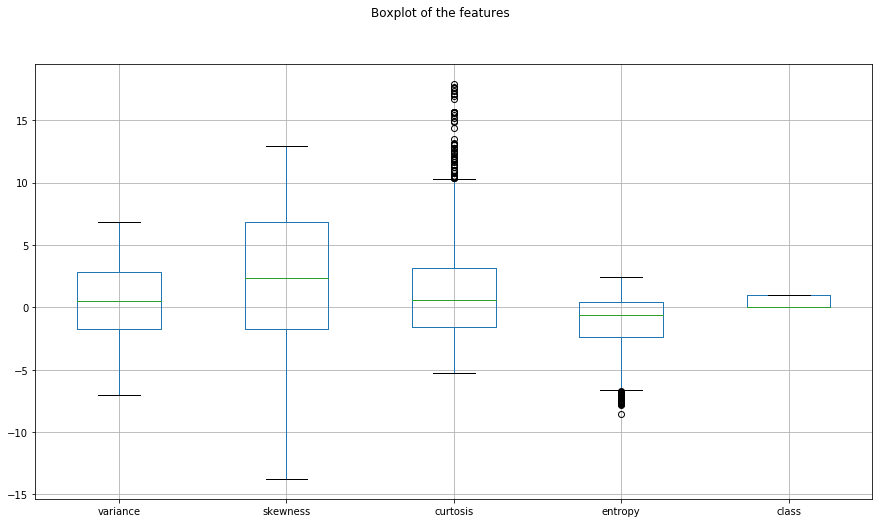

In [3]:
#visualize dataset with pairplot, histogram, and boxplot

plt.figure()
pairplot = sns.pairplot(dataset, hue="class")
pairplot.fig.suptitle("Plot matrix of the features",y=1.04)

plt.show()
dataset.boxplot(figsize=(15,8))
plt.suptitle("Boxplot of the features")

<h2>Histogram plots</h2>
<p>Here we plot histograms of our features. We can see that some of our features have a skewed distribution.</p>

Text(0.5, 0.98, 'Histogram of the features')

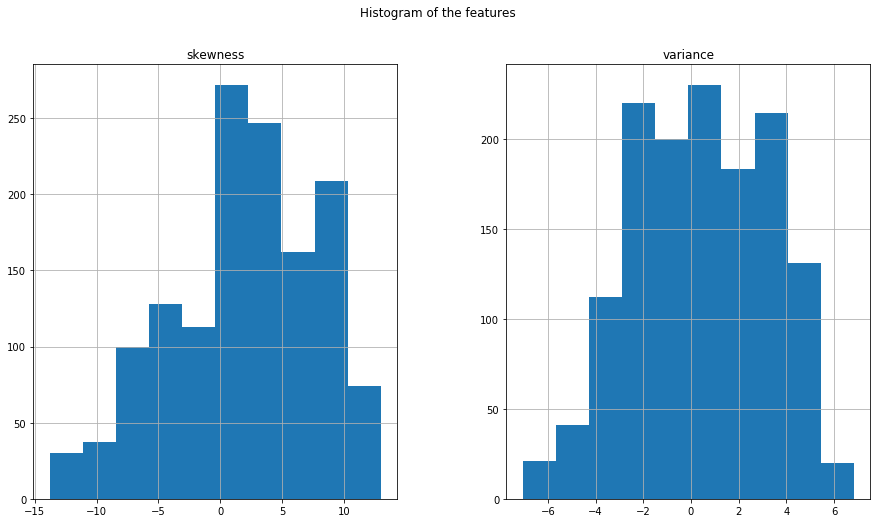

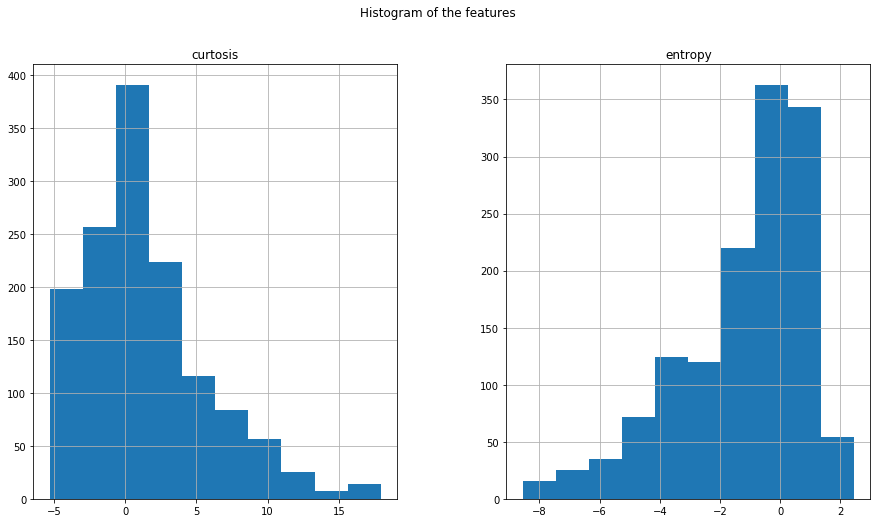

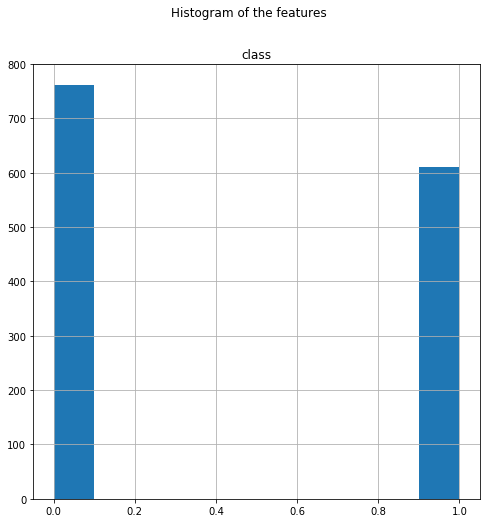

In [4]:

plt.show()
dataset.hist(column=["variance","skewness"],figsize=(15,8))
plt.suptitle("Histogram of the features")
dataset.hist(column=["curtosis","entropy"],figsize=(15,8))
plt.suptitle("Histogram of the features")
dataset.hist(column=["class"],figsize=(8,8))
plt.suptitle("Histogram of the features")


<h2>Outlier detection and Dataset cleaning</h2>
<p>In this section we check for null values in the dataset and describe the dataset statistically.</p>

In [8]:
#check for nulls in dataset and describe the dataset statistically

print(dataset.isna().sum())

dataset.describe()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64


,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


<h2>Correlation matrix and Data preprocessing (scaling)</h2>
<ul><li><p>In this section we create and display a correlation matrix to see how correlated the features are. As you can see, skewness and curtosis are somewhat inversely correlated, but not enough that we can drop one of the features.</p></li>
<li><p>We then scale the data according to their distributions. Here the features "variance" and "skewness" have no outliers and can be scaled using the StandardScaler. But the features "curtosis" and "entropy" have outliers and should be scaled with a PowerTransformer due to the skewness of their distribution and existence of outliers</p></li>
<li>We then check if PCA is plausible with a minimum explained variance of 95%. Here we can see that we can reduce the features into 3 PCA components with an explained variance of 93%. This does not satisfy our criteria of 95% explained variance. Since our dataset does not have a lot of features, we can ignore the PCA method.</li></ul>
 

array([0.53969053, 0.85995509, 0.93921899, 1.        ])

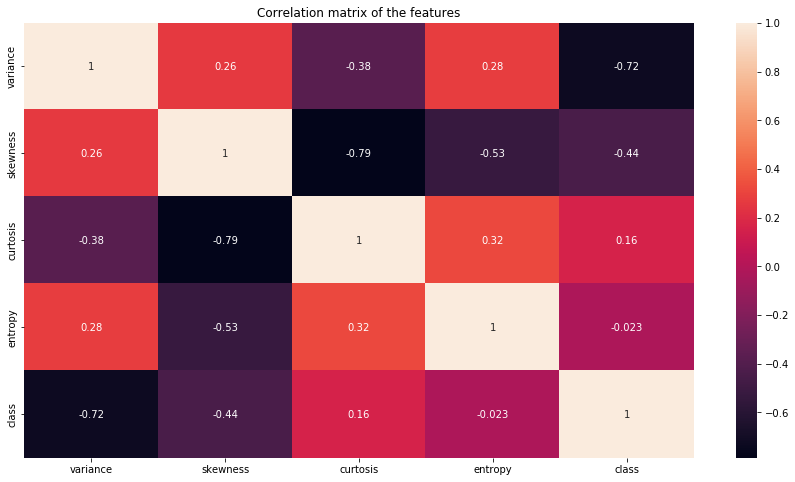

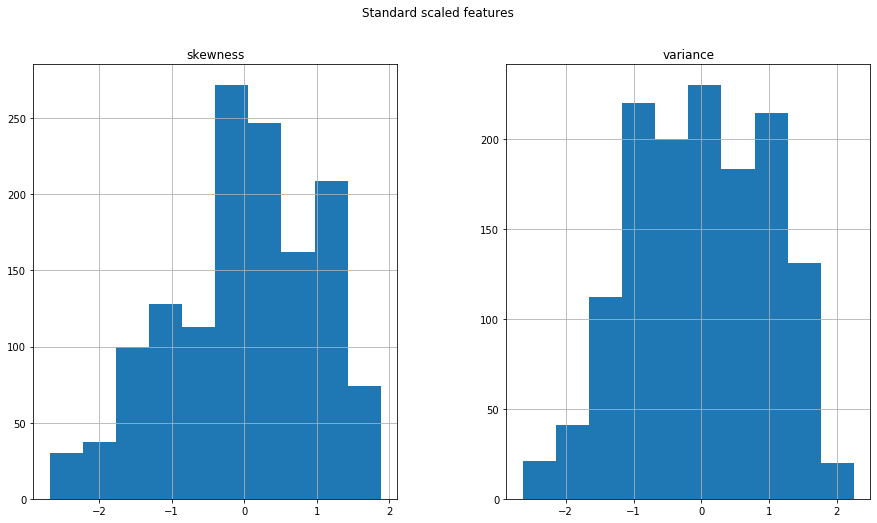

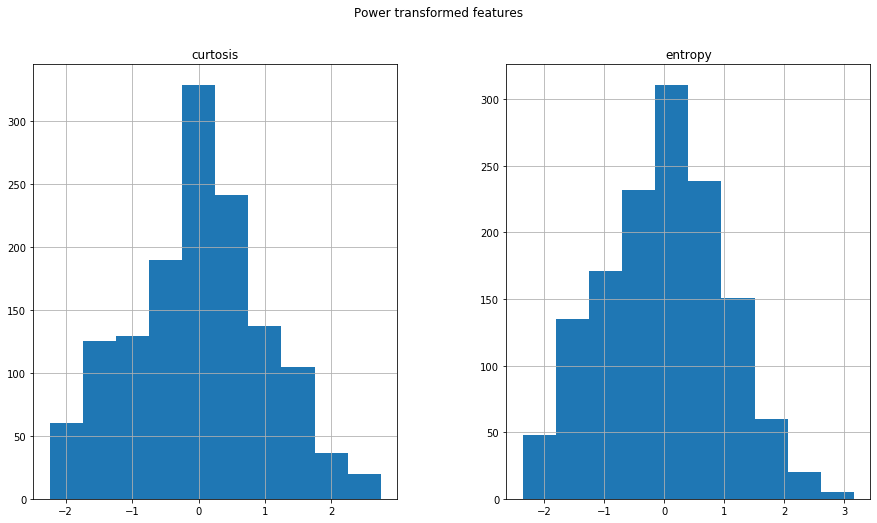

In [9]:
#create a correlation matrix to see how correlated the features are
#from the result we can see than skewness and curtosis are somewhat inversely correlated, but not enough that we can drop one of the features
y = dataset["class"]
x = dataset.drop(["class"],axis=1)

plt.figure(figsize=(15,8))
corr_matrix = sns.heatmap(dataset.corr(),annot=True)
plt.title("Correlation matrix of the features")


#scaling the dataset with standard scaler (removing mean and scales variable to unit variance)
standard_scaler = StandardScaler()
# x_scaled = standard_scaler.fit_transform(x)

power_transformer = PowerTransformer()
standard_scaled = pd.DataFrame(standard_scaler.fit_transform(x[["variance","skewness"]]),columns=["variance","skewness"])
power_transformed = pd.DataFrame(power_transformer.fit_transform(x[["curtosis","entropy"]]),columns=["curtosis","entropy"])
x_scaled = pd.concat([standard_scaled,power_transformed],axis=1)

standard_scaled.hist(figsize=(15,8))
plt.suptitle("Standard scaled features")
power_transformed.hist(figsize=(15,8))
plt.suptitle("Power transformed features")

#check if PCA makes sense or is worth it in our case
pca_95 = PCA(n_components=0.95, random_state=0)
x_pca_95 = pca_95.fit_transform(x_scaled)

#To get an explained variance of 95%, we still need 4 variables/features, which is why PCA does not make sense in our case
np.cumsum(pca_95.explained_variance_ratio_)



<h2>The SVC model</h2>
<p>We define 3 SVC models, each with a different type of kernel to evaluate the performance of each kernel.</p>

In [10]:
#define a SVC classifier estimator with an RBF kernel (produces the best result, 2nd one would be linear kernel) and fit the training data to the estimator


estimators = {
    "linear":svm.SVC(kernel="linear",C=1),
    "rbf":svm.SVC(kernel="rbf",C=1),
    "poly":svm.SVC(kernel="poly",C=1)
}


<h2>Sequential Feature Selection</h2>
<p>The Sequential Feature Selector from sklearn is used to reduce the amount of features to 3.</p>

In [11]:
# from sklearn.feature_selection import SequentialFeatureSelector

# sfs = SequentialFeatureSelector(estimator=estimators["linear"],)
# x_reduced = sfs.fit_transform(x_scaled,y)

<h2>Train test split</h2>
<p> We then split the data to 80% training data and 20% test data

In [26]:
#splitting the training data and test data to 80 : 20 with the scaled x

x_train, x_test, y_train, y_test = train_test_split(x_scaled,y,test_size=0.2,random_state=2)

<h2>Testing the performance of the SVM models with different numbers of features</h2>
<p>In this part we try to vary the input features and test the accuracy scores of the SVM models. Since we only have 4 features, this is relatively easy to do.</p> 
<p>From this part we can see that the test accuracy reaches around 98% with 3 features using the linear and RBF kernel. But since the 4 feature model still performs better, we do not drop any features from the input.</p>

In [27]:
from itertools import permutations

for name, estimator in estimators.items():
    print(name)
    print("1 variable accuracy scores")
    for column in x_train:
        estimator.fit(x_train[column].to_numpy().reshape(-1,1),y_train)
        prediction_1var = estimator.predict(x_test[column].to_numpy().reshape(-1,1))
        print(f"Accuracy for {column} : {accuracy_score(y_test,prediction_1var)}")

    print("2 variables accuracy scores")
    combinations = permutations(x_train.columns,2)
    cleaned_combs = []
    seen = set()
    for combs in list(combinations):
        s = frozenset(combs)
        if (s not in seen):
            seen.add(s)
            cleaned_combs.append(combs)
    
    for cmb in cleaned_combs:
        (col1, col2) = cmb
        estimator.fit(x_train[[col1,col2]],y_train)
        print(f"Accuracy for {col1, col2} : {accuracy_score(y_test,estimator.predict(x_test[[col1,col2]]))}")

    print("3 variable accuracy scores")
    for column in x_train:
        estimator.fit(x_train.drop(columns=column),y_train)
        prediction_3var = estimator.predict(x_test.drop(columns=column))
        print(f"Accuracy for {x_train.drop(columns=column).columns} : {accuracy_score(y_test,prediction_3var)}")
    
    print("All variable accuracy scores")
    estimator.fit(x_train,y_train)
    prediction = estimator.predict(x_test)
    print(f"Accuracy for {x_train.columns} : {accuracy_score(y_test,prediction)}")



# for name, estimator in estimators.items():
#     estimator.fit(x_train,y_train)

linear
1 variable accuracy scores
Accuracy for variance : 0.8545454545454545
Accuracy for skewness : 0.6072727272727273
Accuracy for curtosis : 0.52
Accuracy for entropy : 0.52
2 variables accuracy scores
Accuracy for ('variance', 'skewness') : 0.8327272727272728
Accuracy for ('variance', 'curtosis') : 0.8945454545454545
Accuracy for ('variance', 'entropy') : 0.8581818181818182
Accuracy for ('skewness', 'curtosis') : 0.7527272727272727
Accuracy for ('skewness', 'entropy') : 0.7709090909090909
Accuracy for ('curtosis', 'entropy') : 0.52
3 variable accuracy scores
Accuracy for Index(['skewness', 'curtosis', 'entropy'], dtype='object') : 0.8
Accuracy for Index(['variance', 'curtosis', 'entropy'], dtype='object') : 0.92
Accuracy for Index(['variance', 'skewness', 'entropy'], dtype='object') : 0.8327272727272728
Accuracy for Index(['variance', 'skewness', 'curtosis'], dtype='object') : 0.9890909090909091
All variable accuracy scores
Accuracy for Index(['variance', 'skewness', 'curtosis', 'e

<h2>Cross Validation</h2>
<p>A stratified 5-fold cross validation is performed to check if the model is overfitted.</p>

In [28]:
#do a cross validation with 10 stratified k-folds with our estimator and the full dataset
for name, estimator in estimators.items():
    scores_cv5 = cross_val_score(estimator,x_scaled,y,cv=5)
    print("5 fold cross validation result:")
    print(f"{name} kernel: {scores_cv5.mean():0.9f} accuracy with a standard deviation of {scores_cv5.std():0.9f}")


5 fold cross validation result:
linear kernel: 0.997815528 accuracy with a standard deviation of 0.001783621
5 fold cross validation result:
rbf kernel: 1.000000000 accuracy with a standard deviation of 0.000000000
5 fold cross validation result:
poly kernel: 0.982508295 accuracy with a standard deviation of 0.001446887


<h2>Evaluation of results</h2>
<p>The confusion matrix and the ROC-AUC curve is used here to check the performance of our model. Furthermore, we alse use the evaluation metrics like accuracy, precision, f1-score, and recall.</p>

Kernel used for the SVML: linear
Accuracy : 1.00
Precision : 1.00
F1 Score : 1.00
Recall : 1.00
[0. 0. 1.] [0. 1. 1.] [2 1 0]


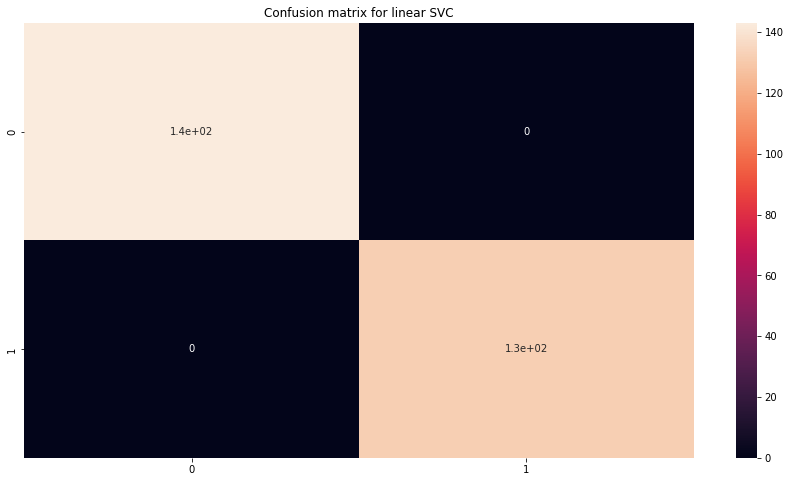

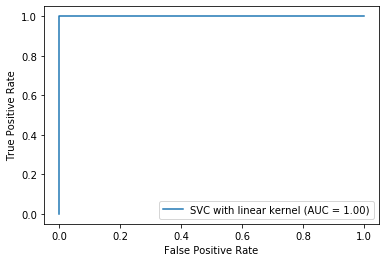

Kernel used for the SVML: rbf
Accuracy : 1.00
Precision : 1.00
F1 Score : 1.00
Recall : 1.00
[0. 0. 1.] [0. 1. 1.] [2 1 0]


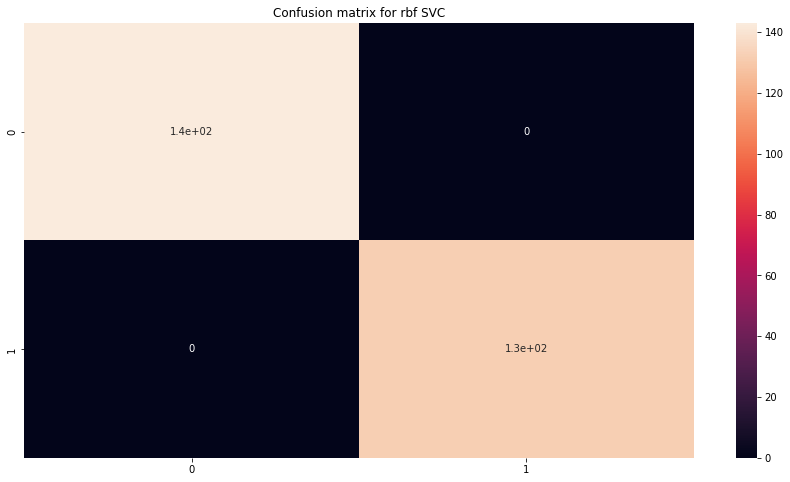

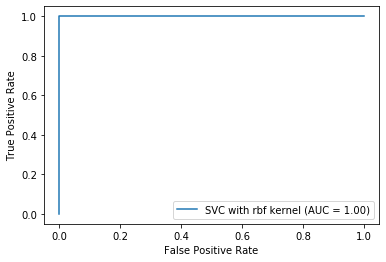

Kernel used for the SVML: poly
Accuracy : 0.99
Precision : 1.00
F1 Score : 0.98
Recall : 0.97
[0. 0. 1.] [0.         0.96969697 1.        ] [2 1 0]


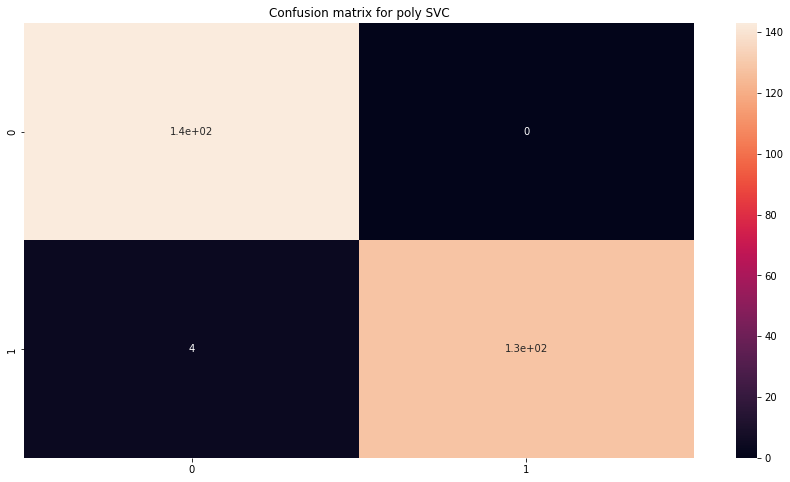

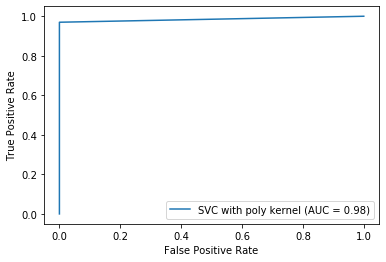

In [29]:
#predicting the classes of the test dataset and creating a confusion matrix to check how good our model is performing


for name, estimator in estimators.items():
    print("Kernel used for the SVML: {}".format(name))
    y_pred = estimator.predict(x_test)
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(15,8))
    plt.title(f"Confusion matrix for {name} SVC")
    sns.heatmap(cm,annot=True)

    #get evaluation metrics accuracy, precision, f1 score, recall
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)

    print(f"Accuracy : {accuracy:.2f}")
    print(f"Precision : {precision:.2f}")
    print(f"F1 Score : {f1:.2f}")
    print(f"Recall : {recall:.2f}")

    #create the roc curve and plot out the roc-auc curve
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    print(fpr,tpr,thresholds)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr,tpr=tpr,roc_auc=roc_auc,estimator_name=f'SVC with {name} kernel')

    display.plot()

    plt.show()




<h2>Display learning curve</h2>
<p>In this part, we display the learning curve of the model by plotting the number of training samples to the scores</p>

109 samples were used to train the model
The average train accuracy is nan
The average test accuracy is nan
161 samples were used to train the model
The average train accuracy is nan
The average test accuracy is nan
213 samples were used to train the model
The average train accuracy is nan
The average test accuracy is nan
265 samples were used to train the model
The average train accuracy is nan
The average test accuracy is nan
317 samples were used to train the model
The average train accuracy is nan
The average test accuracy is nan
369 samples were used to train the model
The average train accuracy is nan
The average test accuracy is nan
421 samples were used to train the model
The average train accuracy is nan
The average test accuracy is nan
473 samples were used to train the model
The average train accuracy is nan
The average test accuracy is nan
525 samples were used to train the model
The average train accuracy is nan
The average test accuracy is nan
577 samples were used to tra

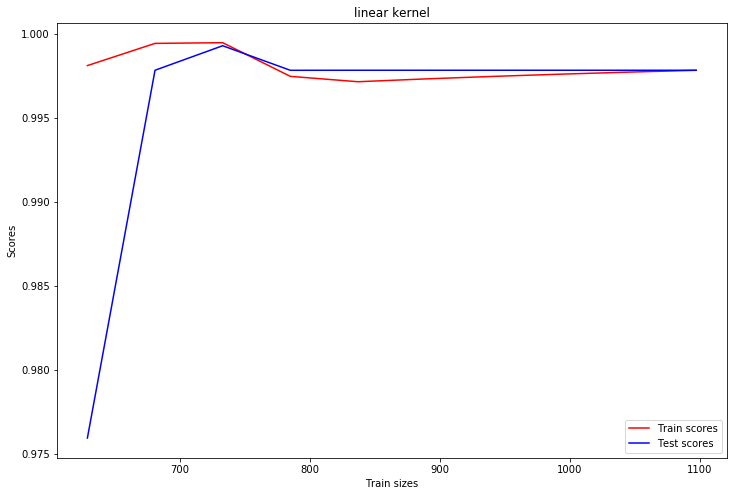

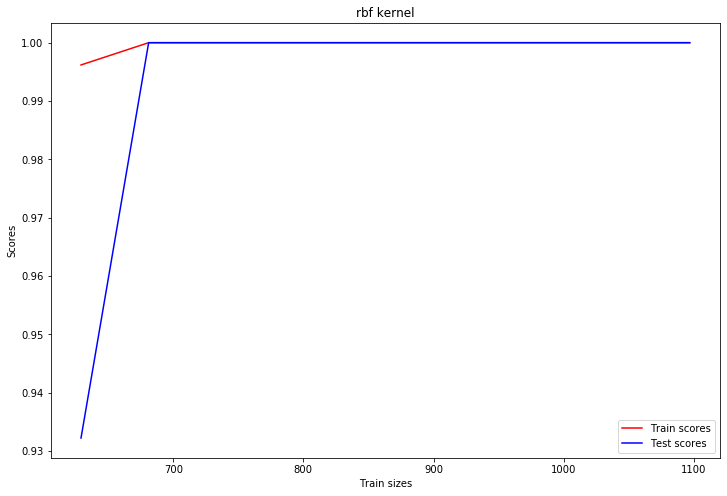

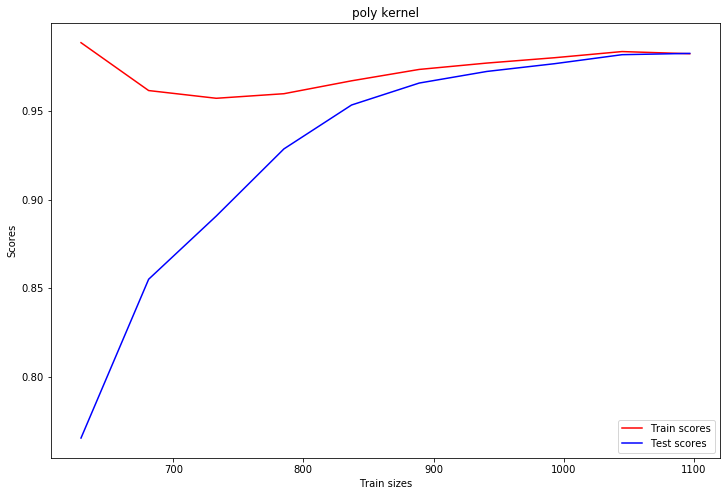

In [30]:
from sklearn.model_selection import learning_curve

for name,estimator in estimators.items():
    train_size = np.linspace(0.1,1,20)
    train_sizes_abs, train_scores, test_scores = learning_curve(estimator,x_scaled,y,train_sizes=train_size)

    scores_train = []
    scores_test = []

    for train_size, cv_train_scores, cv_test_scores in zip(train_sizes_abs,train_scores,test_scores):
        print(f"{train_size} samples were used to train the model")
        print(f"The average train accuracy is {cv_train_scores.mean():.6f}")
        print(f"The average test accuracy is {cv_test_scores.mean():.6f}")
        scores_train.append(cv_train_scores.mean())
        scores_test.append(cv_test_scores.mean())
        
    plt.figure(figsize=(12,8))
    plt.plot(train_sizes_abs,scores_train,'r',label='Train scores')
    plt.xlabel('Train sizes')
    plt.ylabel('Scores')
    plt.plot(train_sizes_abs,scores_test,'b',label='Test scores')
    plt.title(f"{name} kernel")
    plt.legend(loc="lower right")